In [56]:
import sys,os

data_path = os.getcwd()

try:
    import localgraphclustering as lgc
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    import localgraphclustering as lgc

In [57]:
import time
import numpy as np

import matplotlib.pyplot as plt

# Import the graph_tool module for visualization.
from graph_tool.all import * 

import statistics as stat_

# The following code is for random generation of colors.
# See here: https://stackoverflow.com/questions/14720331/how-to-generate-random-colors-in-matplotlib
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np

    np.random.seed(seed=10)
    np.random.RandomState(seed=10)

    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

# Load graph

In [58]:
# Read graph. This also supports gml format.
#g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
g = lgc.GraphLocal('./datasets/sfld_brown_et_al_amidohydrolases_protein_similarities_for_beh.graphml','graphml',' ')
# To get a quick look at the list of methods and attributes for the graph object 'g' you can type 'g.' + tab
# and scroll up or down.

vol_G = g.vol_G

## Load graph using GraphTool. We do this to handle some meta-data which LocalGraphClustering is not handling yet.

In [59]:
g_gtool = load_graph('datasets/sfld_brown_et_al_amidohydrolases_protein_similarities_for_beh.graphml')
remove_self_loops(g_gtool)

n = g_gtool.num_vertices()

## Load coordinates for graph layout

In [60]:
# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/sfld_brown_et_al_amidohydrolases_protein_similarities_for_beh_coordinates.xy', dtype = 'str')

temp = []
for i in ld_coord:
    temp.append(i[0])

idxs = dict(zip(temp, range(len(temp)))) 

pos = g_gtool.new_vertex_property("vector<double>")
for i in ld_coord:
    pos[idxs[i[0]]] = i[1:3]

## Load and filter ground truth clusters. This part takes a while to run. The results are saved in results/

In [12]:
g_v_prop = g_gtool.vertex_properties
groups = np.loadtxt('./datasets/sfld_brown_et_al_amidohydrolases_protein_similarities_for_beh.class', dtype = 'float')
feature_list = [groups]

number_feature = 0

ref_nodes = []
info_ref_nodes = []

for kk in feature_list:
    
    feature = kk

    for ff in list(set(feature)):
        
        if ff == 0:
            continue

        feature_array = np.zeros(n)
        feature_ff_nodes = []
        for i in range(n):
            feature_array[i] = feature[i]
            if feature_array[i] == ff:
                feature_ff_nodes.append(i)

        g_ff = g_gtool.copy()

        del_list_ff = list(set(range(n)) - set(feature_ff_nodes))

        for v in reversed(sorted(del_list_ff)):
            g_ff.remove_vertex(v)   

        n_ff = g_ff.num_vertices() 

        comp_ff,hist_ff=label_components(g_ff)

        feature_ff_nodes_largest_component = []
        for i in range(n_ff):
            if comp_ff[i] == 0:
                feature_ff_nodes_largest_component.append(feature_ff_nodes[i])    

        vol_ff = sum(g.d[feature_ff_nodes_largest_component])
        
        if vol_ff < 100:
            continue
            
        #temp = np.zeros(n)
        #temp[feature_ff_nodes_largest_component] = 1
        
        #cut_ff = vol_ff - (g.adjacency_matrix.dot(temp).transpose()).dot(temp)
        #cond_ff = cut_ff/min(vol_ff,vol_G - vol_ff)
        cond_ff = g.compute_conductance(feature_ff_nodes_largest_component,cpp=True)
        
        if cond_ff > 0.47:
            continue
            
        print("Reached")
        eig_ff, lambda_ff = lgc.fiedler_local(g, feature_ff_nodes_largest_component)
        lambda_ff = np.real(lambda_ff)
        gap_ff = lambda_ff/cond_ff
        
        print("Number of feature", number_feature, "Feature value ", ff, " gap ",gap_ff, " volume: ", vol_ff, " size:", len(feature_ff_nodes_largest_component), "conductance: ", cond_ff)
        
        if gap_ff >= 0.5 and vol_ff >= 100:
            ref_nodes.append(feature_ff_nodes_largest_component)
            info_ref_nodes.append([number_feature,ff])
            np.save('results/ref_nodes_sfld', ref_nodes) 
            np.save('results/info_ref_nodes_sfld', info_ref_nodes) 
        
    number_feature += 1

Reached
Number of feature 0 Feature value  22.0  gap  [0.91796738]  volume:  16209.0  size: 100 conductance:  0.42254370102471367


## If you have generated the ground truth datasets once, you can avoid rerunning the above code and simple run the code below.

In [61]:
ref_nodes = np.load('results/ref_nodes_sfld.npy') 
info_ref_nodes = np.load('results/info_ref_nodes_sfld.npy') 

## Visualize the ground truth clusters

In [62]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 3

temp[list(ref_nodes[0])] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in list(ref_nodes[0]):
    temp[i] = "green"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=1,
           edge_color = [0.0, 0, 0, 0.02],
           #vcmap = c_map
           output='sfld_selected.png'
          )

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x132604470, at 0x1325f3d30>

## Results by spectral algorithm: https://dl.acm.org/citation.cfm?id=1170528 

In [15]:
nodes = {}
external_best_cond_acl = {}
external_best_pre_cond_acl = {}
gap_best_cond_acl = {}
gap_best_pre_acl = {}
vol_best_cond_acl = {}
vol_best_pre_acl = {}
size_clust_best_cond_acl = {}
size_clust_best_pre_acl = {}
f1score_best_cond_acl = {}
f1score_best_pre_acl = {}
true_positives_best_cond_acl = {}
true_positives_best_pre_acl = {}
precision_best_cond_acl = {}
precision_best_pre_acl = {}
recall_best_cond_acl = {}
recall_best_pre_acl = {}
cuts_best_cond_acl = {}
cuts_best_pre_acl = {}
cuts_acl_ALL = {}

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
    eigv, lambda_val = lgc.fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    step = (2*lambda_val - lambda_val/2)/4
    
    a_list = np.arange(lambda_val/2,2*lambda_val,step)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for a in a_list:

            rho = 0.2/sum(g.d[rr])
            
            output_pr_clustering = lgc.spectral_clustering(g,ref_node,method="l1reg",alpha=a,rho=rho,epsilon=1.0e-2,iterations=1000)
            
            S_l1pr = output_pr_clustering[0]
            
            cuts_acl_ALL[ct_outer,node,ct_inner] = S_l1pr
            
            size_clust_acl_ = len(S_l1pr)
            
            cond_val_l1pr = output_pr_clustering[1]
            
            vol_ = sum(g.d[S_l1pr])
            true_positives_acl_ = set(rr).intersection(S_l1pr)
            if len(true_positives_acl_) == 0:
                true_positives_acl_ = set(ref_node)
                vol_ = g.d[ref_node][0,0]
            precision = sum(g.d[np.array(list(true_positives_acl_))])/vol_
            recall = sum(g.d[np.array(list(true_positives_acl_))])/sum(g.d[rr])
            f1_score_ = 2*(precision*recall)/(precision + recall)
            
            if f1_score_ >= max_precision:
            
                max_precision = f1_score_
            
                if len(S_l1pr) == 1:
                    S_smqi_val = 1
                else:
                    S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                    S_smqi_val = np.real(S_smqi_val)

                external_best_pre_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_pre_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_pre_acl[ct_outer,node] = vol_

                size_clust_best_pre_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_pre_acl[ct_outer,node] = true_positives_acl_
                precision_best_pre_acl[ct_outer,node] = precision
                recall_best_pre_acl[ct_outer,node] = recall
                f1score_best_pre_acl[ct_outer,node] = f1_score_
                
                cuts_best_pre_acl[ct_outer,node] = S_l1pr
                
            if cond_val_l1pr <= min_conduct:
            
                min_conduct = cond_val_l1pr
            
                if len(S_l1pr) == 1:
                    S_smqi_val = 1
                else:
                    S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                    S_smqi_val = np.real(S_smqi_val)

                external_best_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_cond_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_cond_acl[ct_outer,node] = vol_

                size_clust_best_cond_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_cond_acl[ct_outer,node] = true_positives_acl_
                precision_best_cond_acl[ct_outer,node] = precision
                recall_best_cond_acl[ct_outer,node] = recall
                f1score_best_cond_acl[ct_outer,node] = f1_score_
                
                cuts_best_cond_acl[ct_outer,node] = S_l1pr

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_acl[ct_outer,node], 'f1score: ', f1score_best_pre_acl[ct_outer,node], 'precision: ', precision_best_pre_acl[ct_outer,node], 'recall: ', recall_best_pre_acl[ct_outer,node])
        ct += 1
    ct_outer += 1
    
    np.save('results/size_clust_best_cond_acl_sfld', size_clust_best_cond_acl) 
    np.save('results/external_best_cond_acl_sfld', external_best_cond_acl)
    np.save('results/vol_best_cond_acl_sfld', vol_best_cond_acl) 
    np.save('results/gap_best_cond_acl_sfld', gap_best_cond_acl) 
    np.save('results/cuts_best_cond_acl_sfld', cuts_best_cond_acl) 
    np.save('results/true_positives_best_cond_acl_sfld', true_positives_best_cond_acl)
    np.save('results/f1score_best_cond_acl_sfld', f1score_best_cond_acl) 
    np.save('results/precision_best_cond_acl_sfld', precision_best_cond_acl) 
    np.save('results/recall_best_cond_acl_sfld', recall_best_cond_acl) 

    np.save('results/size_clust_best_pre_acl_sfld', size_clust_best_pre_acl) 
    np.save('results/external_best_pre_cond_acl_sfld', external_best_pre_cond_acl)
    np.save('results/vol_best_pre_acl_sfld', vol_best_pre_acl) 
    np.save('results/gap_best_pre_acl_sfld', gap_best_pre_acl) 
    np.save('results/cuts_best_pre_acl_sfld', cuts_best_pre_acl) 
    np.save('results/true_positives_best_pre_acl_sfld', true_positives_best_pre_acl)
    np.save('results/f1score_best_pre_acl_sfld', f1score_best_pre_acl) 
    np.save('results/precision_best_pre_acl_sfld', precision_best_pre_acl) 
    np.save('results/recall_best_pre_acl_sfld', recall_best_pre_acl) 

    np.save('results/cuts_acl_ALL_sfld', cuts_acl_ALL) 
    
    np.save('results/nodes_sfld', nodes)

50
outer: 0 number of node:  51  completed:  0.0  degree:  157.0
conductance:  0.4126234435379991 f1score:  0.8243996097069655 precision:  0.8415370774964658 recall:  0.8079462027268801
outer: 0 number of node:  109  completed:  0.02  degree:  174.0
conductance:  0.4398547435315479 f1score:  0.718070260931201 precision:  0.5601479075232402 recall:  1.0
outer: 0 number of node:  130  completed:  0.04  degree:  170.0
conductance:  0.4683935820606998 f1score:  0.7535300050428644 precision:  0.770281590308654 recall:  0.7374915170584243
outer: 0 number of node:  83  completed:  0.06  degree:  148.0
conductance:  0.4265454779862051 f1score:  0.8759266239477322 precision:  0.892237793562424 recall:  0.860201122832994
outer: 0 number of node:  117  completed:  0.08  degree:  163.0
conductance:  0.45757243337420145 f1score:  0.780924274770815 precision:  0.795052099980822 recall:  0.7672897772842248
outer: 0 number of node:  55  completed:  0.1  degree:  159.0
conductance:  0.4126234435379991 

## Improve the results found by the spectral algorithm using MQI

In [16]:
nodes = np.load('results/nodes_sfld.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_sfld.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="mqi")
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/cuts_acl_flow_mqi_sfld', cuts_acl_flow)
    np.save('results/size_clust_acl_flow_mqi_sfld', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_mqi_sfld', external_cond_acl_flow)
    np.save('results/vol_acl_flow_mqi_sfld', vol_acl_flow) 
    np.save('results/gap_acl_flow_mqi_sfld', gap_acl_flow) 
    np.save('results/cuts_acl_flow_mqi_sfld', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_mqi_sfld', true_positives_acl_flow)
    np.save('results/recall_acl_flow_mqi_sfld', recall_acl_flow) 
    np.save('results/precision_acl_flow_mqi_sfld', precision_acl_flow) 
    np.save('results/f1score_acl_flow_mqi_sfld', f1score_acl_flow) 

50
outer: 0 number of node:  51  completed:  0.0  degree:  157.0
conductance:  0.4126234435379991 f1score:  0.7200799644602399 precision:  0.5625976189649786 recall:  1.0
outer: 0 number of node:  109  completed:  0.02  degree:  174.0
conductance:  0.4126234435379991 f1score:  0.7200799644602399 precision:  0.5625976189649786 recall:  1.0
outer: 0 number of node:  130  completed:  0.04  degree:  170.0
conductance:  0.46773250146227335 f1score:  0.7566780605139891 precision:  0.7768895821147722 recall:  0.7374915170584243
outer: 0 number of node:  83  completed:  0.06  degree:  148.0
conductance:  0.4265454779862051 f1score:  0.8759266239477322 precision:  0.892237793562424 recall:  0.860201122832994
outer: 0 number of node:  117  completed:  0.08  degree:  163.0
conductance:  0.4506080509852377 f1score:  0.7875007914899006 precision:  0.808805358652533 recall:  0.7672897772842248
outer: 0 number of node:  55  completed:  0.1  degree:  159.0
conductance:  0.4126234435379991 f1score:  0.

## Improve the results found by the spectral algorithm using FlowImprove (SimpleLocal with delta=0)

In [17]:
nodes = np.load('results/nodes_sfld.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_sfld.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=0.0000000001)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/cuts_acl_flow_sfld', cuts_acl_flow) 
    np.save('results/size_clust_acl_flow_flowImprove_sfld', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_flowImprove_sfld', external_cond_acl_flow)
    np.save('results/vol_acl_flow_flowImprove_sfld', vol_acl_flow) 
    np.save('results/gap_acl_flow_flowImprove_sfld', gap_acl_flow) 
    np.save('results/cuts_acl_flow_flowImprove_sfld', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_flowImprove_sfld', true_positives_acl_flow)
    np.save('results/recall_acl_flow_flowImprove_sfld', recall_acl_flow) 
    np.save('results/precision_acl_flow_flowImprove_sfld', precision_acl_flow) 
    np.save('results/f1score_acl_flow_flowImprove_sfld', f1score_acl_flow) 

50
outer: 0 number of node:  51  completed:  0.0  degree:  157.0
conductance:  0.4126234435379991 f1score:  0.7200799644602399 precision:  0.5625976189649786 recall:  1.0
outer: 0 number of node:  109  completed:  0.02  degree:  174.0
conductance:  0.4398547435315479 f1score:  0.718070260931201 precision:  0.5601479075232402 recall:  1.0
outer: 0 number of node:  130  completed:  0.04  degree:  170.0
conductance:  0.46773250146227335 f1score:  0.7566780605139891 precision:  0.7768895821147722 recall:  0.7374915170584243
outer: 0 number of node:  83  completed:  0.06  degree:  148.0
conductance:  0.4265454779862051 f1score:  0.8759266239477322 precision:  0.892237793562424 recall:  0.860201122832994
outer: 0 number of node:  117  completed:  0.08  degree:  163.0
conductance:  0.4506080509852377 f1score:  0.7875007914899006 precision:  0.808805358652533 recall:  0.7672897772842248
outer: 0 number of node:  55  completed:  0.1  degree:  159.0
conductance:  0.4126234435379991 f1score:  0.7

outer: 0 number of node:  124  completed:  0.94  degree:  172.0
conductance:  0.45996658527181594 f1score:  0.7319344386069776 precision:  0.7467582488124278 recall:  0.7176877043617743
outer: 0 number of node:  61  completed:  0.96  degree:  155.0
conductance:  0.4220264317180617 f1score:  0.7191375141418398 precision:  0.5614478697609976 recall:  1.0
outer: 0 number of node:  69  completed:  0.98  degree:  152.0
conductance:  0.4126234435379991 f1score:  0.7200799644602399 precision:  0.5625976189649786 recall:  1.0


## Improve the results found by the spectral algorithm using Local FlowImprove (or SimpleLocal since they solve the same optimization problem using a different solver for the subproblem).

In [18]:
nodes = np.load('results/nodes_sfld.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_sfld.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]
        
        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/cuts_acl_flow_localflowImprove_parameter1_sfld', cuts_acl_flow)
    np.save('results/size_clust_acl_flow_localflowImprove_parameter1_sfld', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter1_sfld', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter1_sfld', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter1_sfld', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter1_sfld', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter1_sfld', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter1_sfld', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter1_sfld', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter1_sfld', f1score_acl_flow) 

50
outer: 0 number of node:  51  completed:  0.0  degree:  157.0
conductance:  0.4126234435379991 f1score:  0.7200799644602399 precision:  0.5625976189649786 recall:  1.0
outer: 0 number of node:  109  completed:  0.02  degree:  174.0
conductance:  0.4398547435315479 f1score:  0.718070260931201 precision:  0.5601479075232402 recall:  1.0
outer: 0 number of node:  130  completed:  0.04  degree:  170.0
conductance:  0.46773250146227335 f1score:  0.7566780605139891 precision:  0.7768895821147722 recall:  0.7374915170584243
outer: 0 number of node:  83  completed:  0.06  degree:  148.0
conductance:  0.4265454779862051 f1score:  0.8759266239477322 precision:  0.892237793562424 recall:  0.860201122832994
outer: 0 number of node:  117  completed:  0.08  degree:  163.0
conductance:  0.4506080509852377 f1score:  0.7875007914899006 precision:  0.808805358652533 recall:  0.7672897772842248
outer: 0 number of node:  55  completed:  0.1  degree:  159.0
conductance:  0.4126234435379991 f1score:  0.7

## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set a larger delta parameter. This will produce worse quality solutions, but the running time decreases.

In [19]:
nodes = np.load('results/nodes_sfld.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_sfld.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 2*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/cuts_acl_flow_localflowImprove_parameter2_sfld', cuts_acl_flow)
    np.save('results/size_clust_acl_flow_localflowImprove_parameter2_sfld', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter2_sfld', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter2_sfld', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter2_sfld', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter2_sfld', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter2_sfld', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter2_sfld', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter2_sfld', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter2_sfld', f1score_acl_flow) 

50
outer: 0 number of node:  51  completed:  0.0  degree:  157.0
conductance:  0.4126234435379991 f1score:  0.7200799644602399 precision:  0.5625976189649786 recall:  1.0
outer: 0 number of node:  109  completed:  0.02  degree:  174.0
conductance:  0.4398547435315479 f1score:  0.718070260931201 precision:  0.5601479075232402 recall:  1.0
outer: 0 number of node:  130  completed:  0.04  degree:  170.0
conductance:  0.46773250146227335 f1score:  0.7566780605139891 precision:  0.7768895821147722 recall:  0.7374915170584243
outer: 0 number of node:  83  completed:  0.06  degree:  148.0
conductance:  0.4265454779862051 f1score:  0.8759266239477322 precision:  0.892237793562424 recall:  0.860201122832994
outer: 0 number of node:  117  completed:  0.08  degree:  163.0
conductance:  0.4506080509852377 f1score:  0.7875007914899006 precision:  0.808805358652533 recall:  0.7672897772842248
outer: 0 number of node:  55  completed:  0.1  degree:  159.0
conductance:  0.4126234435379991 f1score:  0.7

outer: 0 number of node:  20  completed:  0.92  degree:  181.0
conductance:  0.4951970851275257 f1score:  0.6691157679529771 precision:  0.6938058959920503 recall:  0.6461225245234129
outer: 0 number of node:  124  completed:  0.94  degree:  172.0
conductance:  0.4640969446951141 f1score:  0.7334110897456104 precision:  0.7498388552275365 recall:  0.7176877043617743
outer: 0 number of node:  61  completed:  0.96  degree:  155.0
conductance:  0.4220264317180617 f1score:  0.7191375141418398 precision:  0.5614478697609976 recall:  1.0
outer: 0 number of node:  69  completed:  0.98  degree:  152.0
conductance:  0.4209104938271605 f1score:  0.8886999779603917 precision:  0.90747170781893 recall:  0.870689123326547


## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set an even larger delta parameter. This will produce evem worse quality solutions, but the running time decreases even more.

In [20]:
nodes = np.load('results/nodes_sfld.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_sfld.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:

    how_many = int(len(rr)/2)
    print(how_many)
    
    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 3*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/cuts_acl_flow_localflowImprove_parameter3_sfld', cuts_acl_flow)
    np.save('results/size_clust_acl_flow_localflowImprove_parameter3_sfld', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter3_sfld', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter3_sfld', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter3_sfld', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter3_sfld', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter3_sfld', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter3_sfld', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter3_sfld', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter3_sfld', f1score_acl_flow) 

50
outer: 0 number of node:  51  completed:  0.0  degree:  157.0
conductance:  0.4126234435379991 f1score:  0.7200799644602399 precision:  0.5625976189649786 recall:  1.0
outer: 0 number of node:  109  completed:  0.02  degree:  174.0
conductance:  0.4398547435315479 f1score:  0.718070260931201 precision:  0.5601479075232402 recall:  1.0
outer: 0 number of node:  130  completed:  0.04  degree:  170.0
conductance:  0.46773250146227335 f1score:  0.7566780605139891 precision:  0.7768895821147722 recall:  0.7374915170584243
outer: 0 number of node:  83  completed:  0.06  degree:  148.0
conductance:  0.4265454779862051 f1score:  0.8759266239477322 precision:  0.892237793562424 recall:  0.860201122832994
outer: 0 number of node:  117  completed:  0.08  degree:  163.0
conductance:  0.4506080509852377 f1score:  0.7875007914899006 precision:  0.808805358652533 recall:  0.7672897772842248
outer: 0 number of node:  55  completed:  0.1  degree:  159.0
conductance:  0.4126234435379991 f1score:  0.7

outer: 0 number of node:  20  completed:  0.92  degree:  181.0
conductance:  0.4951970851275257 f1score:  0.6691157679529771 precision:  0.6938058959920503 recall:  0.6461225245234129
outer: 0 number of node:  124  completed:  0.94  degree:  172.0
conductance:  0.4640969446951141 f1score:  0.7334110897456104 precision:  0.7498388552275365 recall:  0.7176877043617743
outer: 0 number of node:  61  completed:  0.96  degree:  155.0
conductance:  0.4220264317180617 f1score:  0.7191375141418398 precision:  0.5614478697609976 recall:  1.0
outer: 0 number of node:  69  completed:  0.98  degree:  152.0
conductance:  0.4209104938271605 f1score:  0.8886999779603917 precision:  0.90747170781893 recall:  0.870689123326547


## Generate scatter plot

In [21]:
l_info_ref_nodes = len(info_ref_nodes)

nodes = np.load('results/nodes_sfld.npy')
nodes = nodes[()]

external_best_cond_acl = np.load('results/external_best_cond_acl_sfld.npy')
external_best_cond_acl = external_best_cond_acl[()]
external_cond_acl_flow_mqi = np.load('results/external_cond_acl_flow_mqi_sfld.npy')
external_cond_acl_flow_mqi = external_cond_acl_flow_mqi[()]
external_cond_acl_flow_flowImprove = np.load('results/external_cond_acl_flow_flowImprove_sfld.npy')
external_cond_acl_flow_flowImprove = external_cond_acl_flow_flowImprove[()]
external_cond_acl_flow_localflowImprove_parameter1 = np.load('results/external_cond_acl_flow_localflowImprove_parameter1_sfld.npy')
external_cond_acl_flow_localflowImprove_parameter1 = external_cond_acl_flow_localflowImprove_parameter1[()]
external_cond_acl_flow_localflowImprove_parameter2 = np.load('results/external_cond_acl_flow_localflowImprove_parameter2_sfld.npy')
external_cond_acl_flow_localflowImprove_parameter2 = external_cond_acl_flow_localflowImprove_parameter2[()]
external_cond_acl_flow_localflowImprove_parameter3 = np.load('results/external_cond_acl_flow_localflowImprove_parameter3_sfld.npy')
external_cond_acl_flow_localflowImprove_parameter3 = external_cond_acl_flow_localflowImprove_parameter3[()]

precision_mqi = np.load('results/precision_acl_flow_mqi_sfld.npy')
precision_mqi = precision_mqi[()]
recall_mqi = np.load('results/recall_acl_flow_mqi_sfld.npy')
recall_mqi = recall_mqi[()]
f1_mqi = np.load('results/f1score_acl_flow_mqi_sfld.npy')
f1_mqi = f1_mqi[()]
precision_best_cond_acl = np.load('results/precision_best_cond_acl_sfld.npy')
precision_best_cond_acl = precision_best_cond_acl[()]
recall_best_cond_acl = np.load('results/recall_best_cond_acl_sfld.npy')
recall_best_cond_acl = recall_best_cond_acl[()]
f1score_best_cond_acl = np.load('results/f1score_best_cond_acl_sfld.npy')
f1score_best_cond_acl = f1score_best_cond_acl[()]
precision_acl_flow_localflowImprove = np.load('results/precision_acl_flow_flowImprove_sfld.npy')
precision_acl_flow_localflowImprove = precision_acl_flow_localflowImprove[()]
recall_acl_flow_localflowImprove = np.load('results/recall_acl_flow_flowImprove_sfld.npy')
recall_acl_flow_localflowImprove = recall_acl_flow_localflowImprove[()]
f1score_acl_flow_flowImprove = np.load('results/f1score_acl_flow_flowImprove_sfld.npy')
f1score_acl_flow_flowImprove = f1score_acl_flow_flowImprove[()]
precision_acl_flow_localflowImprove_parameter1 = np.load('results/precision_acl_flow_localflowImprove_parameter1_sfld.npy')
precision_acl_flow_localflowImprove_parameter1 = precision_acl_flow_localflowImprove_parameter1[()]
recall_acl_flow_localflowImprove_parameter1 = np.load('results/recall_acl_flow_localflowImprove_parameter1_sfld.npy')
recall_acl_flow_localflowImprove_parameter1 = recall_acl_flow_localflowImprove_parameter1[()]
f1_acl_flow_localflowImprove_parameter1 = np.load('results/f1score_acl_flow_localflowImprove_parameter1_sfld.npy')
f1_acl_flow_localflowImprove_parameter1 = f1_acl_flow_localflowImprove_parameter1[()]
precision_acl_flow_localflowImprove_parameter2 = np.load('results/precision_acl_flow_localflowImprove_parameter2_sfld.npy')
precision_acl_flow_localflowImprove_parameter2 = precision_acl_flow_localflowImprove_parameter2[()]
recall_acl_flow_localflowImprove_parameter2 = np.load('results/recall_acl_flow_localflowImprove_parameter2_sfld.npy')
recall_acl_flow_localflowImprove_parameter2 = recall_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = np.load('results/precision_acl_flow_localflowImprove_parameter3_sfld.npy')
f1_acl_flow_localflowImprove_parameter2 = np.load('results/f1score_acl_flow_localflowImprove_parameter2_sfld.npy')
f1_acl_flow_localflowImprove_parameter2 = f1_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = precision_acl_flow_localflowImprove_parameter3[()]
recall_acl_flow_localflowImprove_parameter3 = np.load('results/recall_acl_flow_localflowImprove_parameter3_sfld.npy')
recall_acl_flow_localflowImprove_parameter3 = recall_acl_flow_localflowImprove_parameter3[()]
f1_acl_flow_localflowImprove_parameter3 = np.load('results/f1score_acl_flow_localflowImprove_parameter3_sfld.npy')
f1_acl_flow_localflowImprove_parameter3 = f1_acl_flow_localflowImprove_parameter3[()]

## Generate scatter plot for F1 score

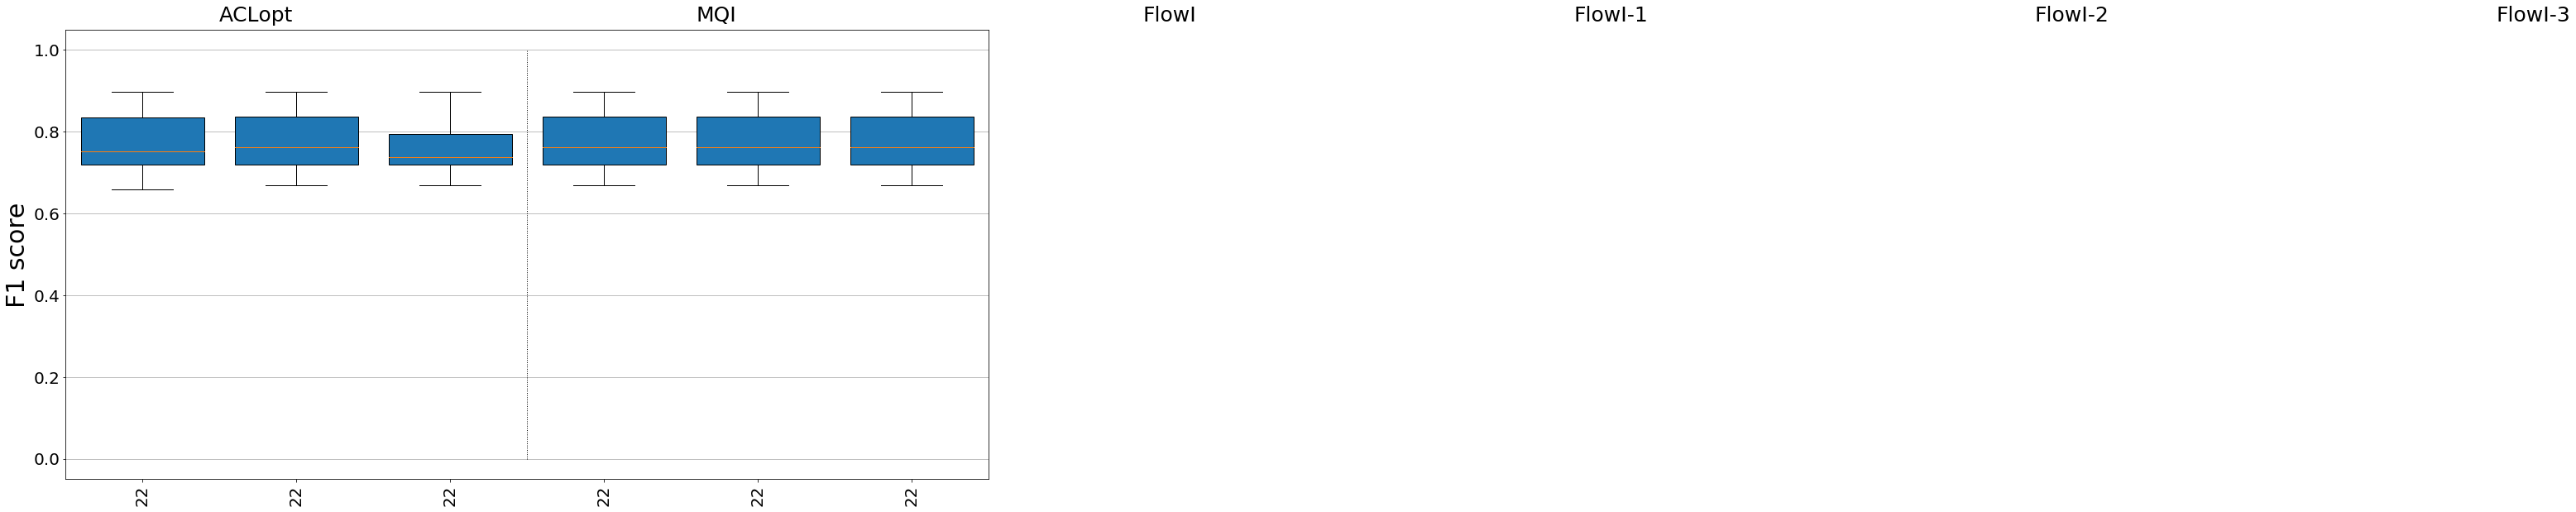

In [22]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_best_cond_acl[i,j])
    all_data.append(temp_f1)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_mqi[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('F1 score',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_sfld_f1.png')

plt.show()

## Generate scatter plot for precision

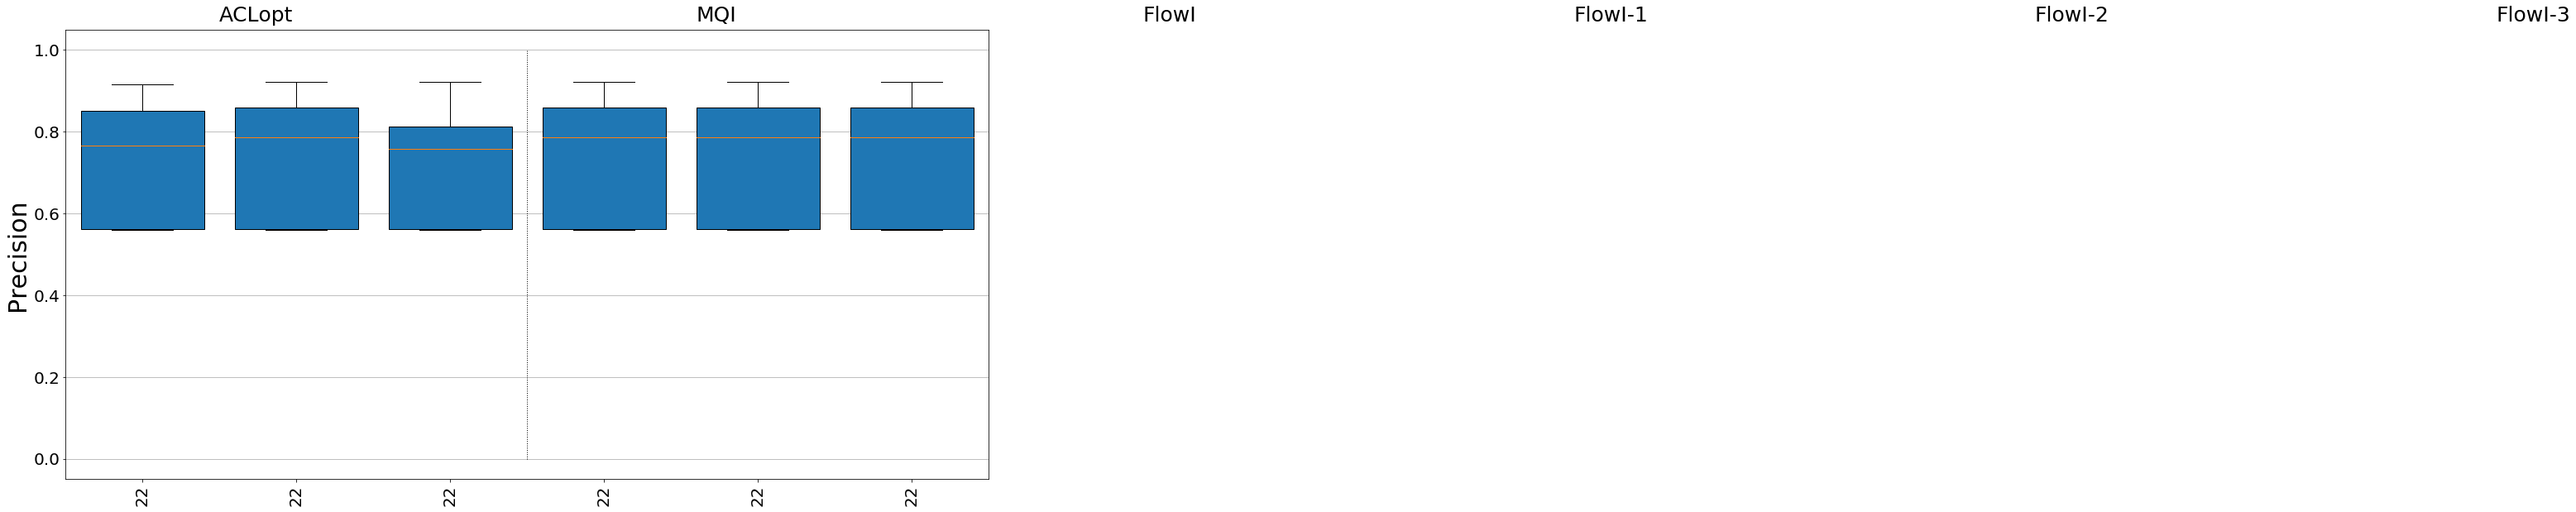

In [23]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
    all_data.append(temp_pre)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1])) 
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Precision',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_sfld_precision.png')

plt.show()

## Generate scatter plot for recall

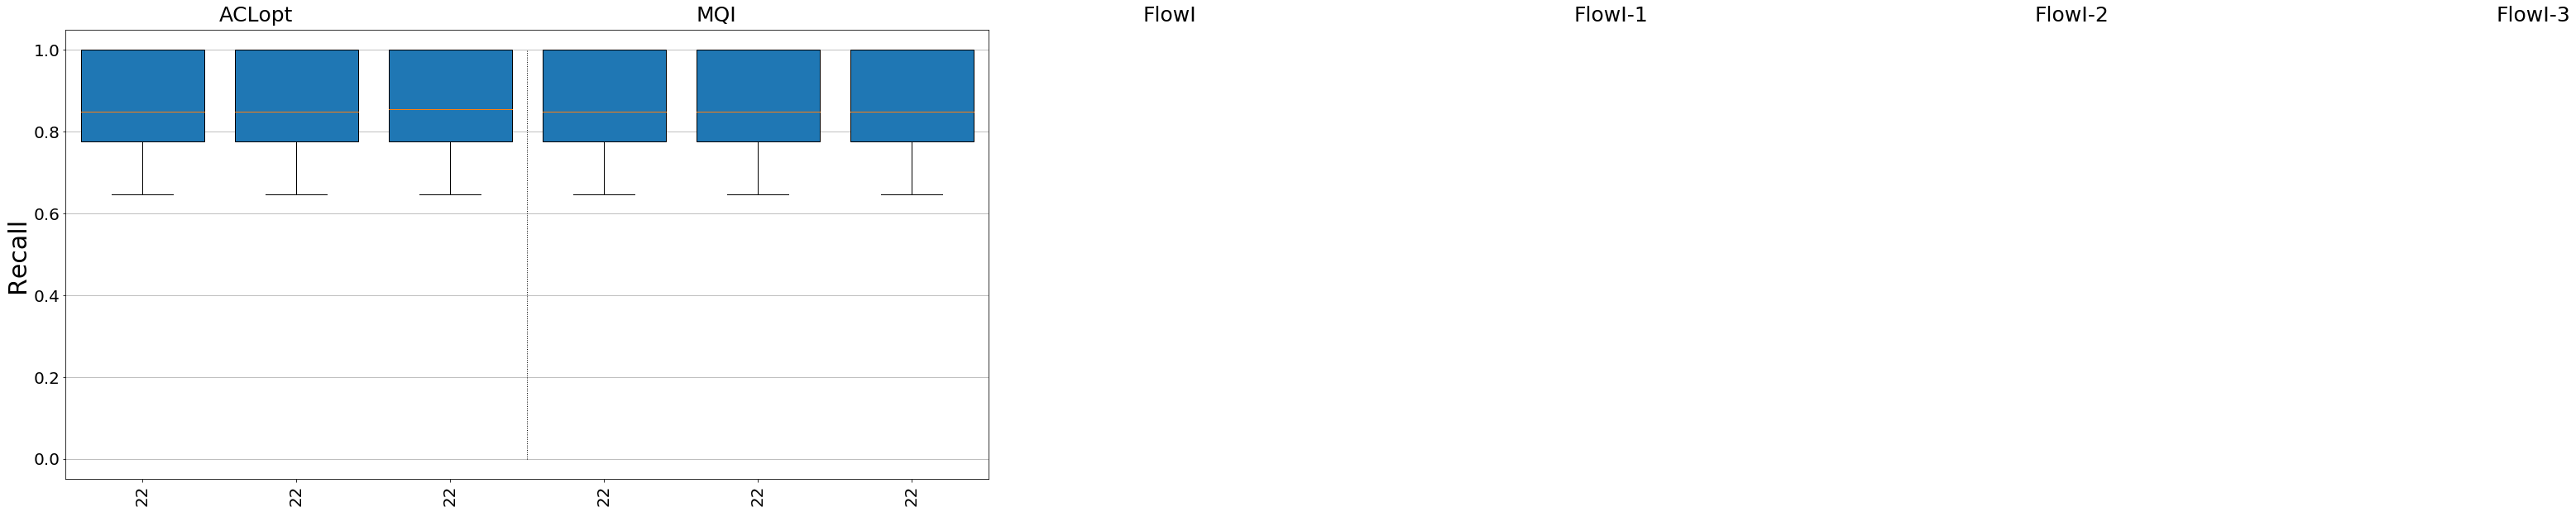

In [24]:
all_data = []
xlabels_ = []

for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_best_cond_acl[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_mqi[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Recall',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_sfld_recall.png')

plt.show()

In [25]:
all_data = []
xlabels_ = []

print('Results for ACL')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
        temp_rec.append(recall_best_cond_acl[i,j])
        temp_f1.append(f1score_best_cond_acl[i,j])
        temp_conductance.append(external_best_cond_acl[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")
    
print('Results for MQI')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
        temp_rec.append(recall_mqi[i,j])
        temp_f1.append(f1_mqi[i,j])
        temp_conductance.append(external_cond_acl_flow_mqi[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

print('Results for FlowI')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
        temp_conductance.append(external_cond_acl_flow_flowImprove[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

print('Results for FlowI-1')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])
        temp_conductance.append(external_cond_acl_flow_localflowImprove_parameter1[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

print('Results for FlowI-2')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
        temp_conductance.append(external_cond_acl_flow_localflowImprove_parameter2[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

print('Results for FlowI-3')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
        temp_conductance.append(external_cond_acl_flow_localflowImprove_parameter3[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

Results for ACL
Feature: 22.0 Precision 0.7665633411665969 Recall 0.8498365105805417 F1 0.751470718690563 Cond. 0.4392165478562424
Average precision 0.7665633411665969 Average recall 0.8498365105805417 Average F1 0.751470718690563 Av. Cond. 0.4392165478562424
 
Results for MQI
Feature: 22.0 Precision 0.7868944537455024 Recall 0.8498365105805417 F1 0.7623382582052671 Cond. 0.4310324681273332
Average precision 0.7868944537455024 Average recall 0.8498365105805417 Average F1 0.7623382582052671 Av. Cond. 0.4310324681273332
 
Results for FlowI
Feature: 22.0 Precision 0.7586647019355912 Recall 0.8550805108273181 F1 0.7378071489150549 Cond. 0.43372117503154256
Average precision 0.7586647019355912 Average recall 0.8550805108273181 Average F1 0.7378071489150549 Av. Cond. 0.43372117503154256
 
Results for FlowI-1
Feature: 22.0 Precision 0.7868944537455024 Recall 0.8498365105805417 F1 0.7623382582052671 Cond. 0.43372117503154256
Average precision 0.7868944537455024 Average recall 0.849836510580541

There are  1  connected components in the graph
Make an NCP object for Improve Algo
There are  1  connected components in the graph
Going into improve mode


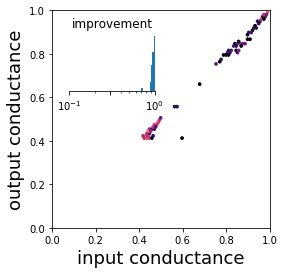

In [26]:
# Read graph. This also supports gml and graphml format.
g.discard_weights()

ncp = lgc.NCPData(g,store_output_clusters=True)
ncp.approxPageRank(ratio=1.0,nthreads=24,localmins=False,neighborhoods=False,random_neighborhoods=False)
sets = [st["output_cluster"] for st in ncp.results]
print("Make an NCP object for Improve Algo")
ncp2 = lgc.NCPData(g)
print("Going into improve mode")
output = ncp2.refine(sets, method='mqi', methodname='MQI', nthreads=24, timeout=1000000, **{"delta": 0})
fig = lgc.NCPPlots(ncp2).mqi_input_output_cond_plot()[0]
#fig.axes[0].set_title(gname + " " + methodname+"-NCP")
fig.savefig("figures/" + 'mqi' + "-ncp-"+'sfld'+".pdf", bbox_inches="tight", figsize=(100,100))
plt.show()

There are  1  connected components in the graph
Make an NCP object for Improve Algo
There are  1  connected components in the graph
Going into improve mode


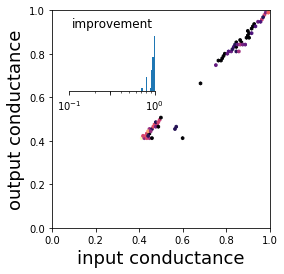

In [27]:
# Read graph. This also supports gml and graphml format.
g.discard_weights()

ncp = lgc.NCPData(g,store_output_clusters=True)
ncp.approxPageRank(ratio=1.0,nthreads=24,localmins=False,neighborhoods=False,random_neighborhoods=False)
sets = [st["output_cluster"] for st in ncp.results]
print("Make an NCP object for Improve Algo")
ncp2 = lgc.NCPData(g)
print("Going into improve mode")
output = ncp2.refine(sets, method='sl', methodname='FlowImprove', nthreads=24, timeout=1000000, **{"delta": 0.00001})
fig = lgc.NCPPlots(ncp2).mqi_input_output_cond_plot()[0]
#fig.axes[0].set_title(gname + " " + methodname+"-NCP")
fig.savefig("figures/" + 'FlowImprove' + "-ncp-"+'sfld'+".pdf", bbox_inches="tight", figsize=(100,100))
plt.show()

There are  1  connected components in the graph
Make an NCP object for Improve Algo
There are  1  connected components in the graph
Going into improve mode


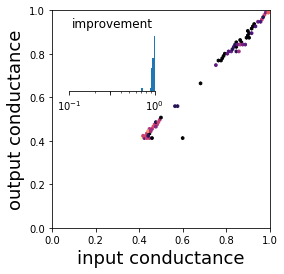

In [28]:
# Read graph. This also supports gml and graphml format.
g.discard_weights()

ncp = lgc.NCPData(g,store_output_clusters=True)
ncp.approxPageRank(ratio=1.0,nthreads=24,localmins=False,neighborhoods=False,random_neighborhoods=False)
sets = [st["output_cluster"] for st in ncp.results]
print("Make an NCP object for Improve Algo")
ncp2 = lgc.NCPData(g)
print("Going into improve mode")
output = ncp2.refine(sets, method='sl', methodname='SimpleLocal', nthreads=24, timeout=1000000, **{"delta": 0.3})
fig = lgc.NCPPlots(ncp2).mqi_input_output_cond_plot()[0]
#fig.axes[0].set_title(gname + " " + methodname+"-NCP")
fig.savefig("figures/" + 'SimpleLocal_0_3' + "-ncp-"+'sfld'+".pdf", bbox_inches="tight", figsize=(100,100))
plt.show()

There are  1  connected components in the graph
Make an NCP object for Improve Algo
There are  1  connected components in the graph
Going into improve mode


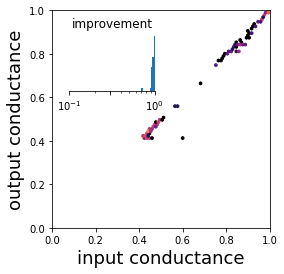

In [29]:
# Read graph. This also supports gml and graphml format.
g.discard_weights()

ncp = lgc.NCPData(g,store_output_clusters=True)
ncp.approxPageRank(ratio=1.0,nthreads=24,localmins=False,neighborhoods=False,random_neighborhoods=False)
sets = [st["output_cluster"] for st in ncp.results]
print("Make an NCP object for Improve Algo")
ncp2 = lgc.NCPData(g)
print("Going into improve mode")
output = ncp2.refine(sets, method='sl', methodname='SimpleLocal', nthreads=24, timeout=1000000, **{"delta": 0.6})
fig = lgc.NCPPlots(ncp2).mqi_input_output_cond_plot()[0]
#fig.axes[0].set_title(gname + " " + methodname+"-NCP")
fig.savefig("figures/" + 'SimpleLocal_0_6' + "-ncp-"+'sfld'+".pdf", bbox_inches="tight", figsize=(100,100))
plt.show()

There are  1  connected components in the graph
Make an NCP object for Improve Algo
There are  1  connected components in the graph
Going into improve mode


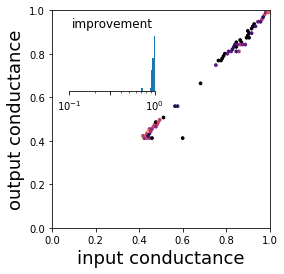

In [30]:
# Read graph. This also supports gml and graphml format.
g.discard_weights()

ncp = lgc.NCPData(g,store_output_clusters=True)
ncp.approxPageRank(ratio=1.0,nthreads=24,localmins=False,neighborhoods=False,random_neighborhoods=False)
sets = [st["output_cluster"] for st in ncp.results]
print("Make an NCP object for Improve Algo")
ncp2 = lgc.NCPData(g)
print("Going into improve mode")
output = ncp2.refine(sets, method='sl', methodname='SimpleLocal', nthreads=24, timeout=1000000, **{"delta": 0.9})
fig = lgc.NCPPlots(ncp2).mqi_input_output_cond_plot()[0]
#fig.axes[0].set_title(gname + " " + methodname+"-NCP")
fig.savefig("figures/" + 'SimpleLocal_0_9' + "-ncp-"+'sfld'+".pdf", bbox_inches="tight", figsize=(100,100))
plt.show()

In [35]:
cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_sfld.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

f1score_best_cond_acl = np.load('results/f1score_best_cond_acl_sfld.npy')
f1score_best_cond_acl = f1score_best_cond_acl[()]

cuts_acl_flow = np.load('results/cuts_acl_flow_sfld.npy')
cuts_acl_flow = cuts_acl_flow[()]

f1score_acl_flow = np.load('results/f1score_acl_flow_flowImprove_sfld.npy')
f1score_acl_flow = f1score_acl_flow[()]

cuts_acl_flow_mqi = np.load('results/cuts_acl_flow_mqi_sfld.npy')
cuts_acl_flow_mqi = cuts_acl_flow_mqi[()]

f1score_acl_flow_mqi = np.load('results/f1score_acl_flow_mqi_sfld.npy')
f1score_acl_flow_mqi = f1score_acl_flow_mqi[()]

cuts_acl_flow_localflowImprove_parameter1 = np.load('results/cuts_acl_flow_localflowImprove_parameter1_sfld.npy')
cuts_acl_flow_localflowImprove_parameter1 = cuts_acl_flow_localflowImprove_parameter1[()]

f1score_acl_flow_localflowImprove_parameter1 = np.load('results/f1score_acl_flow_localflowImprove_parameter1_sfld.npy')
f1score_acl_flow_localflowImprove_parameter1 = f1score_acl_flow_localflowImprove_parameter1[()]

cuts_acl_flow_localflowImprove_parameter2 = np.load('results/cuts_acl_flow_localflowImprove_parameter1_sfld.npy')
cuts_acl_flow_localflowImprove_parameter2 = cuts_acl_flow_localflowImprove_parameter2[()]

f1score_acl_flow_localflowImprove_parameter2 = np.load('results/f1score_acl_flow_localflowImprove_parameter2_sfld.npy')
f1score_acl_flow_localflowImprove_parameter2 = f1score_acl_flow_localflowImprove_parameter2[()]

cuts_acl_flow_localflowImprove_parameter3 = np.load('results/cuts_acl_flow_localflowImprove_parameter1_sfld.npy')
cuts_acl_flow_localflowImprove_parameter3 = cuts_acl_flow_localflowImprove_parameter3[()]

f1score_acl_flow_localflowImprove_parameter3 = np.load('results/f1score_acl_flow_localflowImprove_parameter3_sfld.npy')
f1score_acl_flow_localflowImprove_parameter3 = f1score_acl_flow_localflowImprove_parameter3[()]

In [36]:
experiment = (0,87)
ref_set = list(cuts_best_cond_acl[experiment])

In [43]:
# Conductance before improvement
print("Conductance before improvement:",g.compute_conductance(ref_set))
print("F1score before improvement:",f1score_best_cond_acl[experiment])

# Conductance and F1score for MQI
output_flow_mqi = list(cuts_acl_flow_mqi[experiment])
print("Conductance MQI:",g.compute_conductance(output_flow_mqi))
print("F1score MQI:",f1score_acl_flow_mqi[experiment])

# Conductance and F1score for FlowImprove
output_flowI = list(cuts_acl_flow[experiment])
print("Conductance FlowImprove:",g.compute_conductance(output_flowI))
print("F1score FlowImprove:",f1score_acl_flow[experiment])

# Conductance and F1score for Local FlowImprove delta_1
output_LocalflowI1 = list(cuts_acl_flow_localflowImprove_parameter1[experiment])
print("Conductance Local FlowImprove 1:",g.compute_conductance(output_LocalflowI1))
print("F1score Local FlowImprove 1:",f1score_acl_flow_localflowImprove_parameter1[experiment])

# Conductance and F1score for Local FlowImprove delta_2
output_LocalflowI2 = list(cuts_acl_flow_localflowImprove_parameter2[experiment])
print("Conductance Local FlowImprove 2:",g.compute_conductance(output_LocalflowI2))
print("F1score Local FlowImprove 2:",f1score_acl_flow_localflowImprove_parameter2[experiment])

# Conductance and F1score for Local FlowImprove delta_3
output_LocalflowI3 = list(cuts_acl_flow_localflowImprove_parameter3[experiment])
print("Conductance Local FlowImprove 3:",g.compute_conductance(output_LocalflowI3))
print("F1score Local FlowImprove 3:",f1score_acl_flow_localflowImprove_parameter3[experiment])

Conductance before improvement: 0.4305421259588732
F1score before improvement: 0.8577643275959902
Conductance MQI: 0.429441492808086
F1score MQI: 0.8599058243529375
Conductance FlowImprove: 0.42488888888888887
F1score FlowImprove: 0.7188185990820195
Conductance Local FlowImprove 1: 0.429441492808086
F1score Local FlowImprove 1: 0.8599058243529375
Conductance Local FlowImprove 2: 0.429441492808086
F1score Local FlowImprove 2: 0.8599058243529375
Conductance Local FlowImprove 3: 0.429441492808086
F1score Local FlowImprove 3: 0.8599058243529375


In [50]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 3

temp[ref_set] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in ref_set:
    temp[i] = "yellow"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=1,
           edge_color = [0.0, 0, 0, 0.02],
           #vcmap = c_map
           output='figures/sfld_demonstration_input.png'
          )

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x132daa9b0, at 0x1321d41d0>

In [51]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 3

temp[output_flow_mqi] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in output_flow_mqi:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=1,
           edge_color = [0.0, 0, 0, 0.02],
           #vcmap = c_map
           output='figures/sfld_demonstration_output_mqi.png'
          )

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x132daa9b0, at 0x1321d41d0>

In [52]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 3

temp[output_flowI] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in output_flowI:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=1,
           edge_color = [0.0, 0, 0, 0.02],
           #vcmap = c_map
           output='figures/sfld_demonstration_output_flowI.png'
          )

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x132daa9b0, at 0x1321d41d0>

In [53]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 3

temp[output_LocalflowI1] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in output_LocalflowI1:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=1,
           edge_color = [0.0, 0, 0, 0.02],
           #vcmap = c_map
           output='figures/sfld_demonstration_output_LocalflowI1.png'
          )

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x132daa9b0, at 0x1321d41d0>

In [54]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 3

temp[output_LocalflowI2] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in output_LocalflowI2:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=1,
           edge_color = [0.0, 0, 0, 0.02],
           #vcmap = c_map
           output='figures/sfld_demonstration_output_LocalflowI2.png'
          )

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x132daa9b0, at 0x1321d41d0>

In [55]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 3

temp[output_LocalflowI3] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in output_LocalflowI3:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=1,
           edge_color = [0.0, 0, 0, 0.02],
           #vcmap = c_map
           output='figures/sfld_demonstration_output_LocalflowI3.png'
          )

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x132daa9b0, at 0x1321d41d0>